Create a web page that clusters product images according to either the similarity of the images or the similarity of the texts that describe the images. You can crawl on the web to gather the images use a clustering algorithm of your choice. [5]

# Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import os, glob, shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Images

In [ ]:
input_dir = '/content/drive/My Drive/Y4_T2/Data Mining/Group Work_Clustering techniques in data mining/Q3_Image Clustering/Images/'
glob_dir = input_dir + '*.jpg'

# Preprocess Images

In [ ]:
# resize images to 224x224 to match the size of the input layer of our model for feature extraction
images = [cv2.resize(cv2.imread(file), (224, 224)) for file in glob.glob(glob_dir)]
paths = [file for file in glob.glob(glob_dir)]
# reshape images
images = np.array(np.float32(images).reshape(len(images), -1)/255)

# Feature Extraction

In [ ]:
model = tf.keras.applications.MobileNetV2(include_top=False,
weights='imagenet', input_shape=(224, 224, 3))
predictions = model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)

9420800/9406464 [==============================] - 0s 0us/step


# Train the model using KMeans

In [ ]:
k = 4
kmodel = KMeans(n_clusters = k, random_state=728)
kmodel.fit(pred_images)
kpredictions = kmodel.predict(pred_images)

# Evaluating the model

The value of the silhouette coefﬁcient is between [-1, 1]. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters. The worst value is -1. Values near 0 denote overlapping clusters.

In [ ]:
sil_average = silhouette_score(pred_images, kpredictions)
print(sil_average)

0.006400041


# Optimizing the model

## K value

In [ ]:
sil = []
kl = []
kmax = 20
for k in range(2, kmax+1):
    kmeans2 = KMeans(n_clusters = k).fit(pred_images)
    labels = kmeans2.labels_
    sil.append(silhouette_score(pred_images, labels, metric = 'euclidean'))
    kl.append(k)

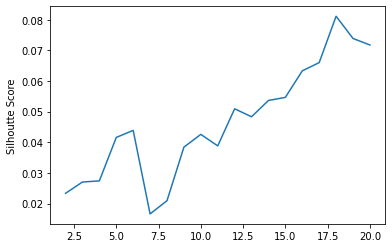

In [ ]:
plt.plot(kl, sil)
plt.ylabel('Silhoutte Score')
plt.show()

Optimal clusters is around 18 that gave highest silhouette score.

In [ ]:
k = 18
kmodel = KMeans(n_clusters = k, random_state=728)
kmodel.fit(pred_images)
kpredictions_1 = kmodel.predict(pred_images)

In [ ]:
sil_average = silhouette_score(pred_images, kpredictions_1)
print(sil_average)

0.07584228


## ResNet50

In [ ]:
from keras.models import Sequential
from keras.applications.resnet import ResNet50

In [ ]:
new_model = Sequential()
new_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3)))

# Say not to train first layer (ResNet) model. It is already trained
new_model.layers[0].trainable = False

predictions = new_model.predict(images.reshape(-1, 224, 224, 3))
pred_images = predictions.reshape(images.shape[0], -1)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
k = 18
kmodel = KMeans(n_clusters = k, random_state=728)
kmodel.fit(pred_images)
kpredictions_2 = kmodel.predict(pred_images)

In [ ]:
sil_average = silhouette_score(pred_images, kpredictions_2)
print(sil_average)

0.22596271


## InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

In [ ]:
# Function to Extract features from the images
def image_feature(direc):
    model = InceptionV3(weights='imagenet', include_top=False)
    features = [];
    img_name = [];
    for i in tqdm(glob.glob(direc)):
        # fname='cluster'+'/'+i
        fname=i
        img=image.load_img(fname,target_size=(224,224))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_name.append(i)
    return features,img_name

In [ ]:
img_features,img_name=image_feature(glob_dir)

87924736/87910968 [==============================] - 1s 0us/step


100%|██████████| 89/89 [00:15<00:00,  5.80it/s]


In [ ]:
#Creating Clusters
k = 18
clusters = KMeans(k, random_state = 40)
clusters.fit(img_features)
kpredictions_3 = clusters.predict(img_features)

In [ ]:
sil_average = silhouette_score(img_features, kpredictions_3)
print(sil_average)

0.07697368


# Output to drive

Optimal transfer learning model is ResNet50 that gave highest silhouette score.

In [ ]:
output = '/content/drive/My Drive/Y4_T2/Data Mining/Group Work_Clustering techniques in data mining/Q3_Image Clustering/Output/'
shutil.rmtree(output)
for i in range(k):
    os.makedirs(output+'cluster' + str(i))
for i in range(len(paths)):
    shutil.copy2(paths[i], output+'cluster'+str(kpredictions_2[i]))